<a href="https://colab.research.google.com/github/Sammm21/ML/blob/main/Multilabelclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-label Classification**

Multi-label classification refers to the problem of identifying the categories of objects in images that may not contain exactly one type of object. There may be more than one kind of object, or there may be no objects at all in the classes that you are looking for.

For instance, this would have been a great approach for our bear classifier. One problem with the bear classifier that we rolled out in <> was that if a user uploaded something that wasn't any kind of bear, the model would still say it was either a grizzly, black, or teddy bear—it had no ability to predict "not a bear at all." In fact, after we have completed this chapter, it would be a great exercise for you to go back to your image classifier application, and try to retrain it using the multi-label technique, then test it by passing in an image that is not of any of your recognized classes.

In practice, we have not seen many examples of people training multi-label classifiers for this purpose—but we very often see both users and developers complaining about this problem. It appears that this simple solution is not at all widely understood or appreciated! Because in practice it is probably more common to have some images with zero matches or more than one match, we should probably expect in practice that multi-label classifiers are more widely applicable than single-label classifiers.

First, let's see what a multi-label dataset looks like, then we'll explain how to get it ready for our model. You'll see that the architecture of the model does not change from the last chapter; only the loss function does. Let's start with the data.

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 9.6MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 194kB 19.6MB/s 
     |████████████████████████████████| 1.2MB 38.9MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *

### **The Data**

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#8) [Path('test.json'),Path('valid.json'),Path('train'),Path('train.json'),Path('test'),Path('test.csv'),Path('train.csv'),Path('segmentation')]

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### **Pandas and DataFrames**

Selects all rows, first column:

In [ ]:
df.iloc[:, 0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

Select first row all columns:

In [ ]:
df.iloc[0,:], df.iloc[0]

(fname       000005.jpg
 labels           chair
 is_valid          True
 Name: 0, dtype: object, fname       000005.jpg
 labels           chair
 is_valid          True
 Name: 0, dtype: object)

Grab column by indexing directly

In [ ]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [ ]:
tmp_df['c'] = tmp_df['a'] + tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### **Construct a DataBlock**

`Dataset` is a collection that returns a tuple with the independent variables and the dependent variable

`DataLoader`: Is an iterator that provides a stream of mini-batches, where each mini-bathc is a tuple of a batch of independent variables and a batch of dependent variables

This is a dataset:

In [ ]:
a = list(enumerate(string.ascii_lowercase))
a[0], len(a)

((0, 'a'), 26)

This is a dataloader:

In [ ]:
dl_a = DataLoader(dataset=a, batch_size=8, shuffle=True)
b = first(dl_a)
b

(tensor([ 7, 24, 17, 21,  5, 19,  9, 15]),
 ('h', 'y', 'r', 'v', 'f', 't', 'j', 'p'))

In [ ]:
list(zip(b[0],b[1]))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [ ]:
list(zip(*b))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [ ]:
a = list(string.ascii_lowercase)
a[0], len(a)

('a', 26)

`Datasets`: Is an object that contains a training `Dataset` and a validation `Dataset`


In [ ]:
dss = Datasets(a)
dss[0]

('a',)

In practice we want to take the above tuple and do something to compute the independent variable and something to compute the dependent variable:

In [ ]:
def f1(o): return o+'a'
def f2(o): return o+'b'

Now we can call `Datasets(a)` and pass it a list of transformation functions:

In [ ]:
dss = Datasets(items=a, tfms=[[f1],[f2]])
dss[0]

('aa', 'ab')

`DataLoaders`: Is an object that containts a training `dataloader` and a validation `dataloader`

Since a `DataLoader` builds on top of a `Dataset` and adds additional functionality to it (collating multiple items into a mini-batch), it’s often easiest to start by creating and testing `Datasets`, and then look at `DataLoaders` after that’s working.

In [ ]:
dls = DataLoaders.from_dsets(dss, batch_size=4)
first(dls.train)

(('ra', 'sa', 'ka', 'wa'), ('rb', 'sb', 'kb', 'wb'))

When we create a DataBlock, we build up gradually, step by step, and use the notebook to check our data along the way. This is a great way to make sure that you maintain momentum as you are coding, and that you keep an eye out for any problems. It’s easy to debug, because you know that if a problem arises, it is in the line of code you just typed!

Let’s start with the simplest case, which is a data block created with no parameters:

In [ ]:
dblock = DataBlock()

We can create a `Datasets` object from this. The only thing needed is a data source- in this case the `DataFrame`

In [ ]:
dsets = dblock.datasets(df)

Once we pass in out `DataFrame` into our `DataBlock` and calling `datasets`the `DataBlock` will take our `DataFrame` and create our training and validation set, which goes back to the definition of a `datasets` which is an object that contains a training `dataset` and a validation `dataset`

In [ ]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

The training set gives us back a independent variable and a dependent variable. However it's not that useful right now since its returning the same thing as the `DataBlock` just assumes we have two things: input and target. We will need to specify the appropriate fields from the `DataFrame` using `get_x` and `get_y`

In [ ]:
x,y = dsets.train[0]
x,y

(fname         002786.jpg
 labels      horse person
 is_valid            True
 Name: 1401, dtype: object, fname         002786.jpg
 labels      horse person
 is_valid            True
 Name: 1401, dtype: object)

In [ ]:
x['fname']

'002786.jpg'

In [ ]:
y['labels']

'horse person'

We can write functions that we then pass to `get_x` and `get_y` to pass our independent and dependent variables to our `DataBlock`

In [ ]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('007204.jpg', 'cat')

Our independents variable will need to be converted to a complete path. so that we can open it as an image, and the dependent variable need to be split on the space character `split(' ')` so that it becomes a list

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('train/002848.jpg'), ['motorbike'])

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x418,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]))

Lets look at the first row in the dependent variable and look for where it is 1. Then pass the `idxs` to vocab to see the label

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['person','sofa']

With NumPy arrays, PyTorch tensors, and fastai’s L class, we can index directly using a list or vector, which makes a lot of code (such as this example) much clearer and more concise.

In [ ]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter, 
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0], dsets.valid[0]

((PILImage mode=RGB size=500x333,
  TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),
 (PILImage mode=RGB size=500x375,
  TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])))

- `Datasets`:: An object that contains a training `Dataset` and a validation `Dataset`
- `DataLoaders`:: An object that contains a training `DataLoader` and a validation `DataLoader`


Also we ensure that every image is the same size with `RandomResizedCrop`

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))  #min scale makes sure the crop isn't too small
dls = dblock.dataloaders(df,batch_size=64)

Display a sample of our data:

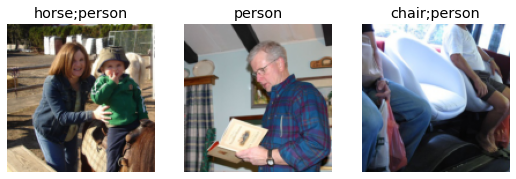

In [ ]:
dls.show_batch(nrows=1, ncols=3)

### **Binary Cross-Entropy**

Now we'll create our `Learner`. We saw in that a `Learner` object contains four main things: the `model`, a `DataLoaders` object, an `Optimizer`, and the `loss` function to use.

In [ ]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


We also saw that the model in a `Learner` is generally an object of a class inheriting from `nn.Module`, and that we can call it using parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini-batch.

In [ ]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

So for every row we have 20 activations since this is a multiclass problem our labels can consist of more than 1 class:

In [ ]:
activs[0]

tensor([-2.5504, -1.4368, -2.4331, -1.5053, -1.0327,  1.9108, -1.1356, -0.9202,  1.2560,  1.7944,  2.0311, -2.3387, -4.0115, -3.8152,  1.5852, -4.3230,  2.5997, -0.4488,  0.7653, -0.6697],
       grad_fn=<SelectBackward>)

They aren’t yet scaled to between 0 and 1, but we learned how to do that in <>, using the sigmoid function. We also saw how to calculate a loss based on categorical cross entropy, with the addition of log as discussed in the last chapter:

note: Getting Model Activations: Knowing how to manually get a mini-batch and pass it into a model, and look at the activations and loss, is really important for debugging your model. It is also very helpful for learning, so that you can see exactly what is going on.

In [ ]:
def binary_cross_entropy(activations, targets):
  inputs = activations.sigmoid()
  return -torch.where(targets==1, 1-inputs, inputs).log().mean()

Note that because we have a one-hot-encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore we can't use `cross_entropy`):

- `softmax`, as we saw, requires that all predictions sum to 1, and tends to push one activation to be much larger than the others (due to the use of exp); however, we may well have multiple objects that we're confident appear in an image, so restricting the maximum sum of activations to 1 is not a good idea. *By the same reasoning, we may want the sum to be less than 1, if we don't think any of the categories appear in an image.*

- `nll_loss`, as we saw, returns the value of just one activation: the single activation corresponding with the single label for an item. This doesn't make sense when we have multiple labels.

On the other hand, the binary_cross_entropy function, which is just mnist_loss along with log, provides just what we need, thanks to the magic of PyTorch's elementwise operations. Each activation will be compared to each target for each column, so we don't have to do anything to make this function work for multiple columns.

`F.binary_cross_entropy` and its module equivalent `nn.BCELoss` calculate cross-entropy on a one-hot-encoded target, but do not include the initial sigmoid. Normally for one-hot-encoded targets you'll want `F.binary_cross_entropy_with_logits` (or `nn.BCEWithLogitsLoss`), which do both sigmoid and binary cross-entropy in a single function, as in the preceding example.

The equivalent for single-label datasets (like MNIST or the Pet dataset), where the target is encoded as a single integer, is `F.nll_loss` or `nn.NLLLoss` for the version without the initial `softmax`, and `F.cross_entropy` or `nn.CrossEntropyLoss` for the version with the initial `softmax`.

Since we have a one-hot-encoded target, we will use `BCEWithLogitsLoss`:

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0696, grad_fn=<AliasBackward>)

In [ ]:
y.shape

torch.Size([64, 20])

In [ ]:
binary_cross_entropy(activs, y)

TensorMultiCategory(1.0616, grad_fn=<AliasBackward>)

Accuracy



```
def accuracy(input, targ, axis=1):
  # "Compute accuracy with 'targ' when 'pred' is bs * n_classes"
  pred = input.argmax(dim=axis)
  return (pred==targ).float().mean()

```

The usual accuracy function will select the class with largest activation and compare that to the target and returning True when it matches and False otherwise. Then that vector of booleans is transformed to floats and the mean of that vector is our accuracy. This doesnt work for multiclass labels though since there can be more than one for a single image.  

Instead after applying the sigmoid function to our activations we need to decide which ones are 0s and which ones are 1s by picking a *threshold*. Each value above the threshold will be considered a 1 and each below a 0.

```
def accuracy_multi(input, targ, thresh=0.5, sigmoid=True):
  # "Compute accuracy when 'input' and 'targ' are the same size"
  if sigmoid: input = input.sigmoid()
  return ((input>thresh)==targ.bool().float().mean()

```
If we'd pass `accuracy_multi` directly as a metric, it will use the default value for `threshold`, which is 0.5. We might want to adjust that default value and create a new version with a different default. 

`partial` helps with that:



In [ ]:
def say_hello(name, say_what='Hello'): return f"{say_what} {name}"
say_hello('Sam'), say_hello('Sam', 'My God is:')

('Hello Sam', 'My God is: Sam')

In [ ]:
f = partial(say_hello, say_what='Talmbout')
f('Sam'), f('chiggs')

('Talmbout Sam', 'Talmbout chiggs')

Train model with 0.2 threshold for the accuracy metric

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.941672,0.697739,0.238147,00:28
1,0.819577,0.557626,0.285319,00:28
2,0.601859,0.202357,0.818984,00:28
3,0.360058,0.125880,0.943486,00:27


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132733,0.114908,0.949681,00:29
1,0.116416,0.108602,0.948307,00:29
2,0.096417,0.104136,0.952092,00:29


Picking threshold although may seem boring is very important- If we pick one that is too low, we will often fail to select correctly labeled objects. Picking one that is too high will only select those objects that the model is most confident in.

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10413588583469391,0.932709276676178]

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10413588583469391,0.9438844323158264]

In [ ]:
preds, targs, = learn.get_preds()

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9565)

We can see the relationship between threshold on the x-axis and accuracy on the y-axis.

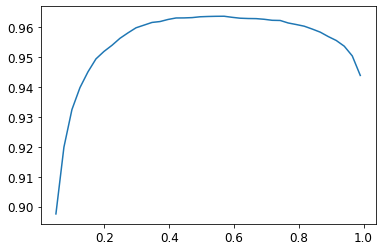

In [ ]:
xs = torch.linspace(0.05,0.99,39)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

## **Regression**

But really, that's hiding a more interesting and deeper perspective. A model is defined by its independent and dependent variables, along with its loss function. That means that there's really a far wider array of models than just the simple domain-based split. Perhaps we have an independent variable that's an image, and a dependent that's text (e.g., generating a caption from an image); or perhaps we have an independent variable that's text and dependent that's an image (e.g., generating an image from a caption—which is actually possible for deep learning to do!); or perhaps we've got images, texts, and tabular data as independent variables, and we're trying to predict product purchases... the possibilities really are endless.

To be able to move beyond fixed applications, to crafting your own novel solutions to novel problems, it helps to really understand the data block API (and maybe also the mid-tier API, which we'll see later in the book). As an example, let's consider the problem of image regression. This refers to learning from a dataset where the independent variable is an image, and the dependent variable is one or more floats. Often we see people treat image regression as a whole separate application—but as you'll see here, we can treat it as just another CNN on top of the data block API.

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
Path.BASE_PATH = path

There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding .obj file for each (we won't need them here). Let's take a look inside one of these directories:

In [ ]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [ ]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Get image by using `get_image_files` and then writing a function that takes the path removes the end characters and adds pose.txt to return the parth for the poses files which is our dependet variable:


In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt') # this function says take the path x remove the 7 characters from the end and add pose.txt to return the path for the poses or our dependent variable
img_files[0],img2pose(img_files[0])

(Path('20/frame_00050_rgb.jpg'), Path('20/frame_00050_pose.txt'))

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

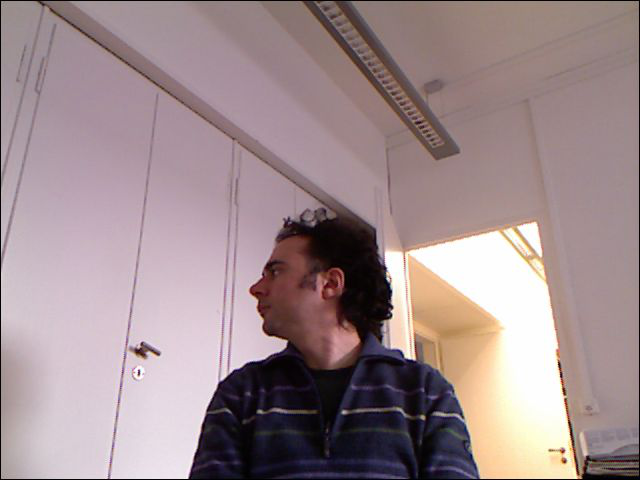

In [ ]:
im.to_thumb(1000)

The Biwi dataset website used to explain the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point:



```
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])```



In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

Function returns coordinates as a tensor of two items:

In [ ]:
get_ctr(img_files[0])

tensor([300.1274, 282.2921])

Time for our DataBlock, we use `ImageBlock` for our independent variable and `PointBlock` for our dependents. We get our images through `get_image_files` and our dependent variable by passing `get_ctr``to `get_y`. We do not want to use a random split since the same person appears in different poses in the dataset therefore we pick 1 person no. 13 for our entire validation dataset. Finally we resize all the images to 240x320 which his half the input size and fastai automatically and correctly will apply data-augmentation which other libraries may not so be careful if using those. 
`Normalize.from_stats`:

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]  # subtract mean of original imagenet dataset and divide by its std to normalize the data
)

Plot some of the data to see if it looks ok:'

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

NameError: ignored

Plot the underlying shape of the tensors representing the independent and dependent variables:


In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

We have a batch size of 64, there are 3 channels in our image RGB we resized our images to be 240x320. For out dependent variable we are looking for the center point which is a coordinate pair. We have a batch size of 64 and 1 row with 2 columns representing the X and Y coordniates of the midpoint of the image.

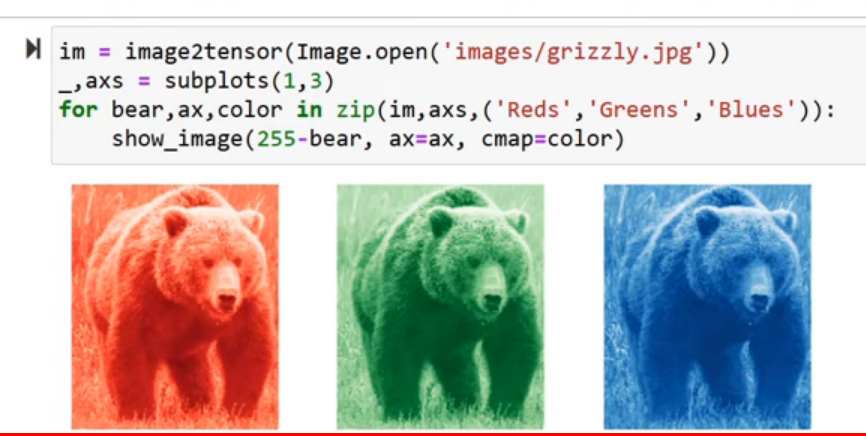

In [ ]:
yb[0]

TensorPoint([[-0.0447,  0.0414]], device='cuda:0')

### **Training The Model**

We use `y_range` to tell fastai the range of our targets in this case (-1,1), which is just how fastai and PyTorch treats coordinates (Top left is -1 and bottom right is 1.)

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

`y_range` is implemented using `sigmoid_range`

In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


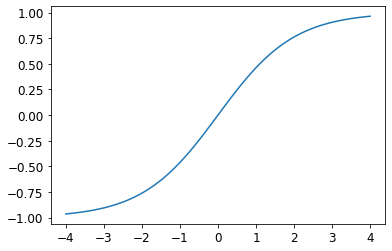

In [ ]:
plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4)

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

his makes sense, since when coordinates are used as the dependent variable, most of the time we're likely to be trying to predict something as close as possible; that's basically what MSELoss (mean squared error loss) does. If you want to use a different loss function, you can pass it to cnn_learner using the loss_func parameter.

Note also that we didn't specify any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root).

We can pick a good learning rate with the learning rate finder:

SuggestedLRs(valley=tensor(0.0017))

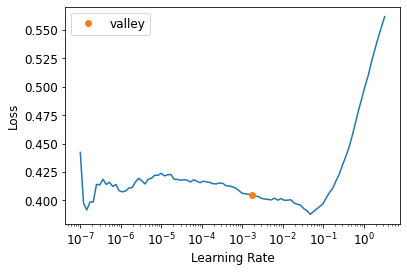

In [ ]:
learn.lr_find()

In [ ]:
lr = 3e-3
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.047691,0.005453,01:58


epoch,train_loss,valid_loss,time
0,0.007740,0.000943,02:08
1,0.003298,0.000754,02:09
2,0.001438,0.000090,02:10


Take the sqrt of the MSE and we can see that on average we are about 0.01 off in a coordinate space that goes between -1 and 1, which is very accurate. 

In [ ]:
math.sqrt(0.0001)

0.01

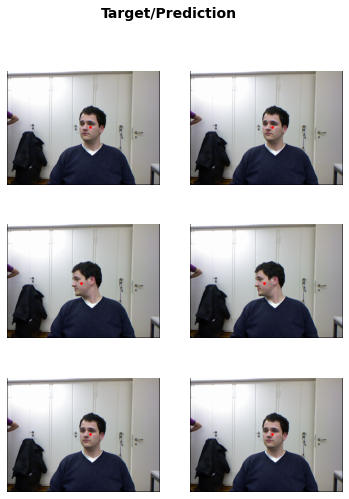

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

Our model seems to be super accurate! Wowy!:)